In [4]:
%pip install  -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.9/62.2 MB 614.2 kB/s eta 0:01:40^C
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.9/62.2 MB 609.6 kB/s eta 0:01:41
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import albumentations as A

In [3]:
import segmentation_models_pytorch as smp

In [4]:
#you might change file pathes to the directories where you extracted these files
df=pd.read_csv('df.csv')
root_path='supervisely_person_clean_2667_img'
df.head()

,Unnamed: 0,images,masks,collages
0,0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,collage/ds10_pexels-photo-687782.jpg
1,1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,collage/ds10_pexels-photo-835971.jpg
2,2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,collage/ds10_pexels-photo-850708.jpg
3,3,images/ds10_pexels-photo-864937.png,masks/ds10_pexels-photo-864937.png,collage/ds10_pexels-photo-864937.jpg
4,4,images/ds10_pexels-photo-865908.png,masks/ds10_pexels-photo-865908.png,collage/ds10_pexels-photo-865908.jpg


/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds10_pexels-photo-687782.png


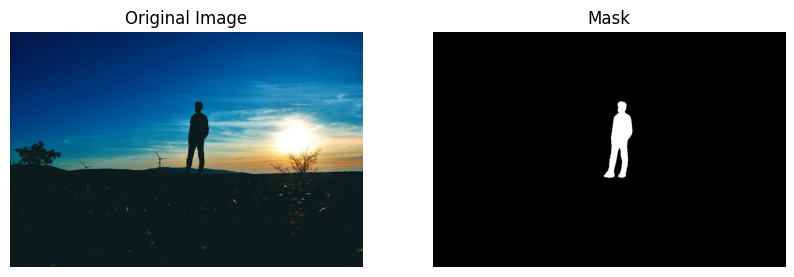

In [5]:
i=0
image_path = os.path.join(root_path, df.loc[i]['images'])
mask_path = os.path.join(root_path, df.loc[i]['masks'])
print(image_path)
image = Image.open(image_path).convert('RGB')
mask= Image.open(mask_path).convert('L')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Plot the mask
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Mask")
axes[1].axis('off')

plt.show()

In [6]:
class Custom_Dataset(Dataset):
    def __init__(self, root_path, df, transform=None):
        self.root_path=root_path
        self.transform=transform
        self.df=df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image_path=os.path.join(self.root_path, self.df.loc[index]['images'])
        mask_path=os.path.join(self.root_path, self.df.loc[index]['masks'])
        image = Image.open(image_path).convert('RGB')
        mask= Image.open(mask_path).convert('L')
        if self.transform:
            image_np = np.array(image)
            mask_np = np.array(mask)

            # Apply Albumentations transformations
            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented['image']
            mask = augmented['mask']

            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return {'image':image, 'mask':mask}


In [21]:
train_transform = A.Compose([
    A.Resize(156, 156),
    A.RandomCrop(height=128, width=128, always_apply=True),
    A.HorizontalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-10,10), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),

    # ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    # ToTensorV2(),
])
dropped_df=df.drop(columns=['collages', 'Unnamed: 0'])
train_df, test_df=train_test_split(dropped_df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(train_df.shape, test_df.shape)
train_df.head()

(2133, 2) (534, 2)


,images,masks
0,images/ds6_pexels-photo-206481.png,masks/ds6_pexels-photo-206481.png
1,images/ds6_wedding-bride-groom-woman-50606.png,masks/ds6_wedding-bride-groom-woman-50606.png
2,images/ds2_pexels-photo-801828.png,masks/ds2_pexels-photo-801828.png
3,images/ds6_pexels-photo-813963.png,masks/ds6_pexels-photo-813963.png
4,images/ds6_pexels-photo-821409.png,masks/ds6_pexels-photo-821409.png


In [23]:
BATCH_SIZE=32
train_data=Custom_Dataset(root_path, train_df, train_transform)
test_data=Custom_Dataset(root_path, test_df, test_transform)

train_loader=DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
model = smp.Unet('resnet18', in_channels=3, classes=1, activation='sigmoid')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s] 


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [24]:
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
min_loss=10000000
train_losses=[]
train_mean_losses=[]
val_losses=[]
val_mean_losses=[]
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for train_vals in train_loader:
        inputs,masks=train_vals['image'], train_vals['mask']
        inputs, masks = inputs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    train_mean_losses.append(np.mean(train_losses))

    # Validation
    model.eval()
    with torch.no_grad():
        for test_vals in test_loader:
            val_inputs,val_masks=test_vals['image'], test_vals['mask']
            val_inputs, val_masks = val_inputs.to(device), val_masks.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_masks)
            
            val_losses.append(val_loss.item())
            if val_loss<min_loss:
                min_loss=val_loss
                torch.save(model.state_dict(), './human_segment.pth')
        val_mean_losses.append(np.mean(val_losses))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(train_losses)}, Val Loss: {np.mean(val_losses)}")


Epoch 1/10, Loss: 0.1979402737386191, Val Loss: 0.15808580070734024
Epoch 2/10, Loss: 0.18234762543840194, Val Loss: 0.16125491677838213
Epoch 3/10, Loss: 0.17451537070582754, Val Loss: 0.15882198088893704
Epoch 4/10, Loss: 0.16815634633400547, Val Loss: 0.15761713026201024
Epoch 5/10, Loss: 0.16369826942682267, Val Loss: 0.15706429577925626
Epoch 6/10, Loss: 0.15999654117063503, Val Loss: 0.1555619211319615
Epoch 7/10, Loss: 0.1567729659426187, Val Loss: 0.15593139558028773


KeyboardInterrupt: 

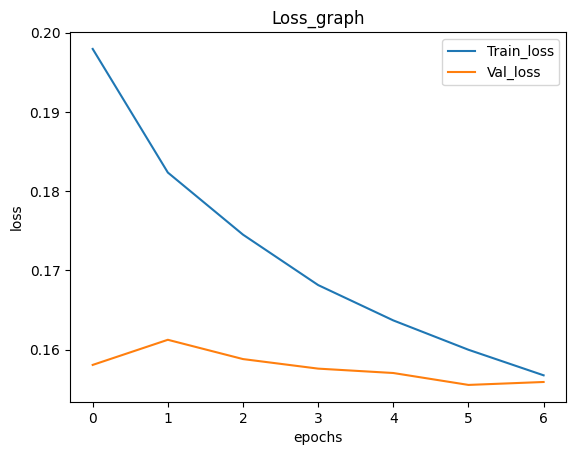

In [29]:
plt.plot(train_mean_losses, label="Train_loss")
plt.plot(val_mean_losses, label="Val_loss")
plt.title('Loss_graph')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

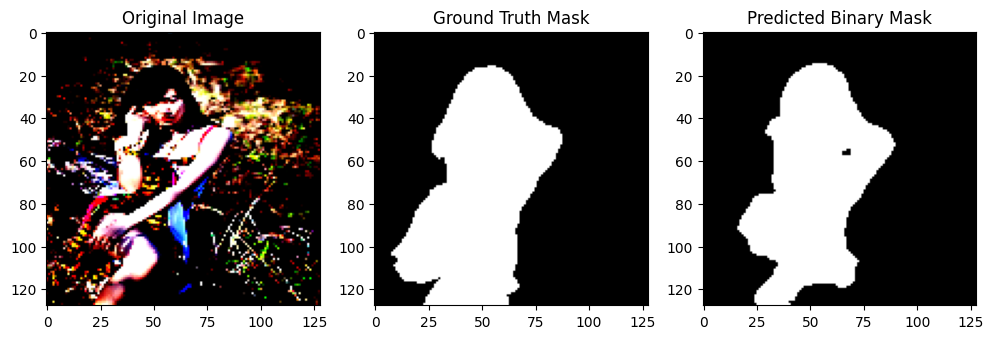

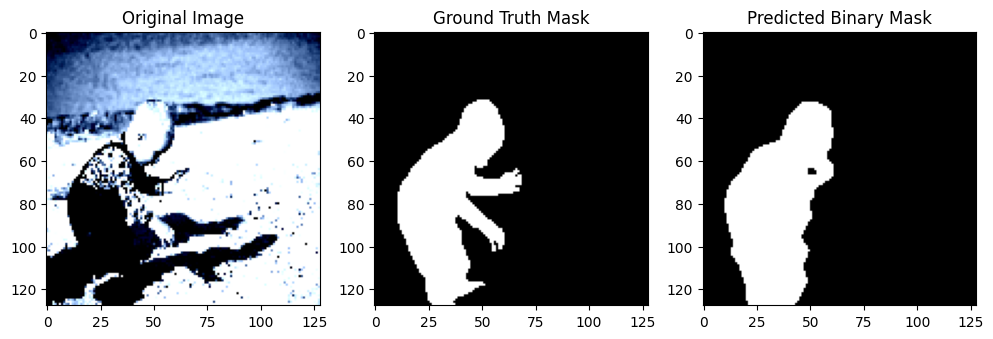

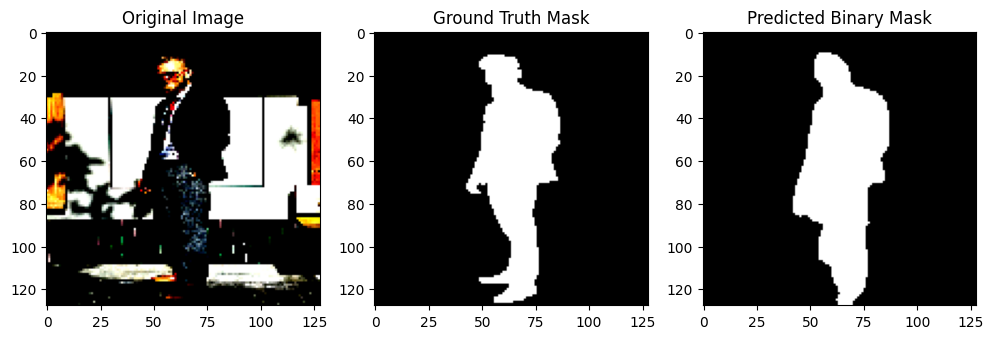

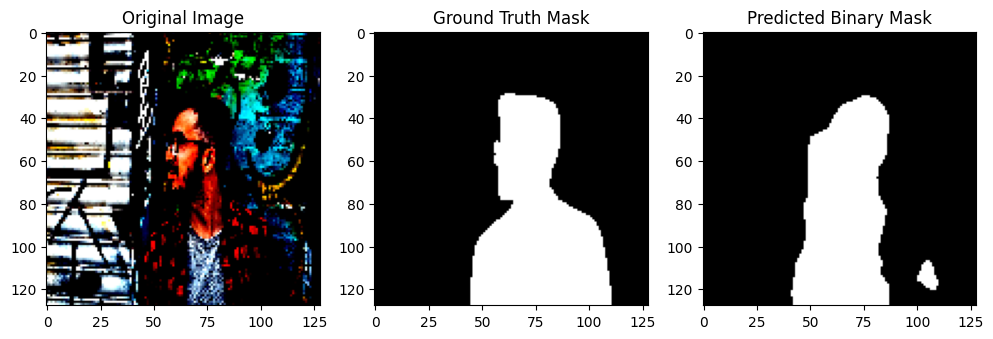

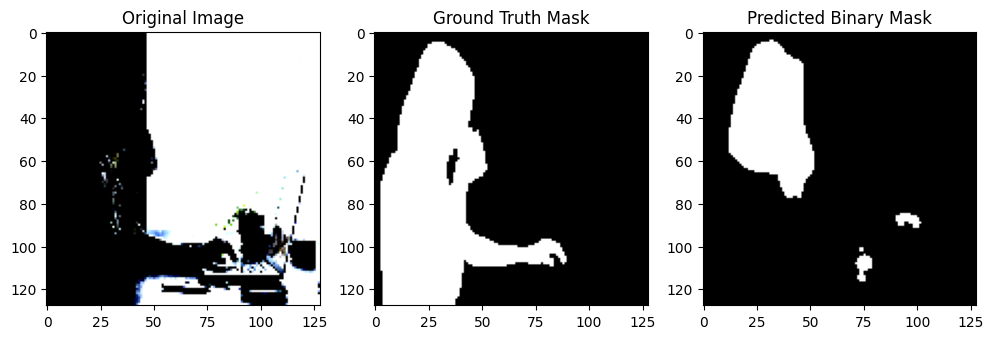

In [33]:
model.load_state_dict(torch.load('human_segment.pth'))

# Set the model to evaluation mode
model.eval()

def visualize_predictions(model, test_vals, device, threshold=0.5):
    with torch.no_grad():
        inputs,masks=test_vals['image'], test_vals['mask']
        inputs, masks = inputs.to(device), masks.to(device)
        model_output = model(inputs)

        binary_mask = (model_output > threshold).float()

        inputs_np = inputs.cpu().numpy()
        masks_np = masks.cpu().numpy()
        binary_mask_np = binary_mask.squeeze().cpu().numpy()


        for i in range(len(inputs)):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(np.transpose(inputs_np[i], (1, 2, 0)))
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(masks_np[i][0], cmap='gray')
            plt.title('Ground Truth Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(binary_mask_np[i], cmap='gray')
            plt.title('Predicted Mask')

            plt.show()


test_loader2 = DataLoader(test_data, batch_size=5, shuffle=True)

example=next(iter(test_loader2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions(model, example, device)
